In [7]:
import numpy as np
import pandas as pd

import torch as t
t.set_default_dtype(t.float32)

import pyro
import pyro.distributions as dist
import pyro.contrib.autoname as au
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, JitTrace_ELBO
from pyro.optim import Adam

import arviz as az
import matplotlib.pyplot as plt

In [11]:
def average(age):
    return np.sum(age)/np.size(age)

def model(program):
    age = pyro.sample('age', dist.Normal(70, 1.))
    program = pyro.deterministic('program', t.tensor(program((age.detach().numpy()))))
    return program

In [12]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc.run(average)

Sample: 100%|██████████| 1100/1100 [00:02, 457.76it/s, step size=1.30e+00, acc. prob=0.911]


In [24]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples=posterior_samples)(average)


pyro_data = az.from_pyro(
    mcmc,
    posterior_predictive=posterior_predictive
)
pyro_data


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age'}>]], dtype=object)

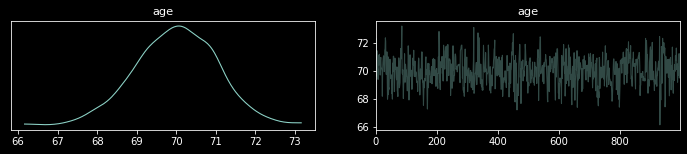

In [25]:
az.plot_trace(pyro_data, compact=True)